In [101]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 사진을 준비하자

(1280, 960, 3)
(541, 597, 3)
(900, 600, 3)
(464, 680, 3)
(269, 300, 3)


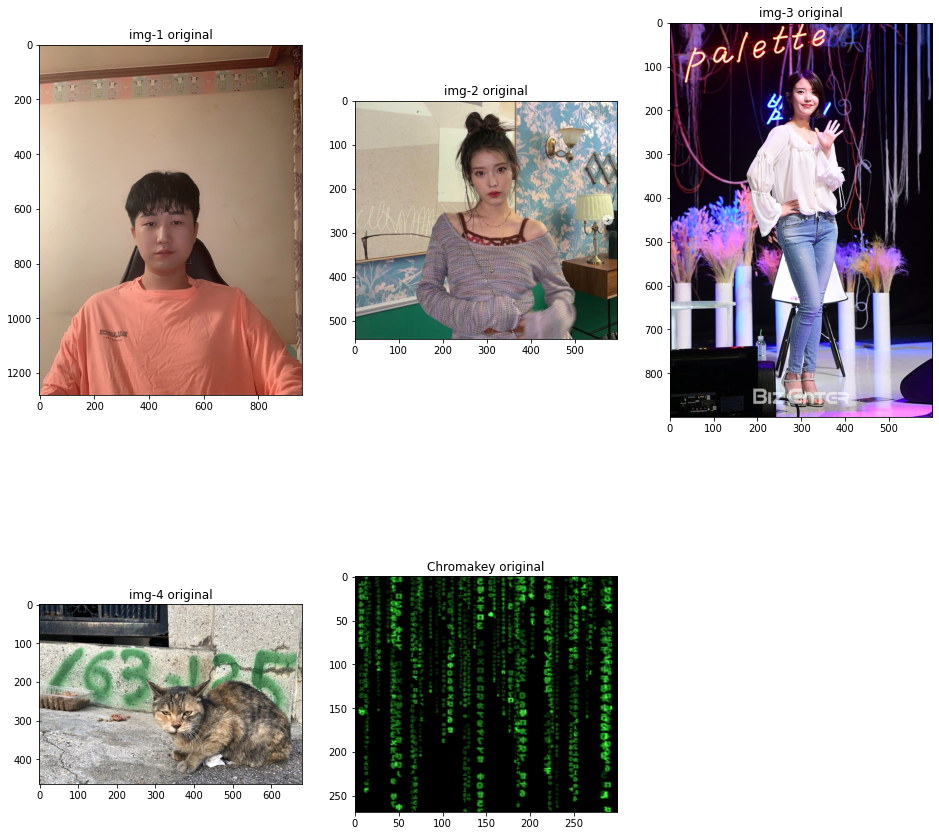

In [119]:
import os

img_orig1 = cv2.imread('images/my_picture.png')
img_orig2 = cv2.imread('images/iu.png')
img_orig3 = cv2.imread('images/iu2.png')
img_orig4 = cv2.imread('images/cat.png')
img_chromakey = cv2.imread('images/chromakey.png')

print (img_orig1.shape)
print (img_orig2.shape)
print (img_orig3.shape)
print (img_orig4.shape)
print (img_chromakey.shape)

plt.figure(figsize=(16,16))

ax = plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
ax.set_title('img-1 original')
ax = plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
ax.set_title('img-2 original')
ax = plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
ax.set_title('img-3 original')
ax = plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
ax.set_title('img-4 original')
ax = plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(img_chromakey, cv2.COLOR_BGR2RGB))
ax.set_title('Chromakey original')

plt.show()

# DeepLab Demo Model 준비

In [103]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

# 사전에 학습된 가중치(pretrained weight)를 가져온다.

In [104]:
#define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getcwd() + '\Ex08\models\\'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


temp directory: C:\Users\jslee\Aiffel\Ex\Ex08\Ex08\models\
model loaded successfully!


In [105]:
img_resized1, seg_map1 = MODEL.run(img_orig1)
img_resized2, seg_map2 = MODEL.run(img_orig2)
img_resized3, seg_map3 = MODEL.run(img_orig3)
img_resized4, seg_map4 = MODEL.run(img_orig4)
print(img_orig1.shape, img_resized1.shape, seg_map1.max())
print(img_orig2.shape, img_resized2.shape, seg_map2.max())
print(img_orig3.shape, img_resized3.shape, seg_map3.max())
print(img_orig4.shape, img_resized4.shape, seg_map4.max())
print(img_orig4.shape, img_resized4.shape, seg_map4.max())

(1280, 960, 3) (513, 384, 3) 15
(541, 597, 3) (464, 513, 3) 15
(900, 600, 3) (513, 341, 3) 15
(464, 680, 3) (350, 513, 3) 8
(464, 680, 3) (350, 513, 3) 8


In [106]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

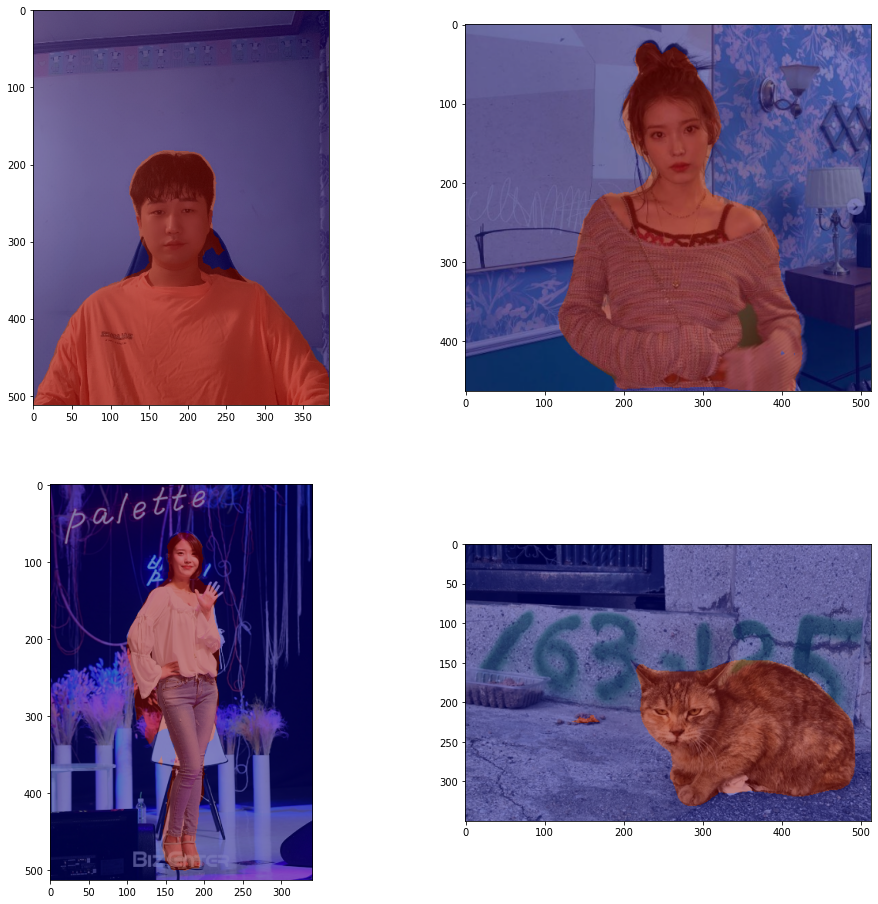

In [107]:
def classfy_img(img_resized, seg_map, nclassfy):
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == nclassfy, nclassfy, 0) # 예측 중 사람만 추출
    img_mask = seg_map*(255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.5, color_mask, 0.5, 0.0) # 0.6, 0.35 에서 좀 더 극명하게 분류해주기 위해 변경
    
    return img_show, img_mask

img_show1, img_mask1 = classfy_img(img_resized1, seg_map1, 15) # 인물: 15
img_show2, img_mask2 = classfy_img(img_resized2, seg_map2, 15) # 인물: 15
img_show3, img_mask3 = classfy_img(img_resized3, seg_map3, 15) # 인물: 15
img_show4, img_mask4 = classfy_img(img_resized4, seg_map4, 8) # 고양이 : 8

plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 결과를 원래 크기로 복원

DeeLap 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했기 때문에 원복해주자

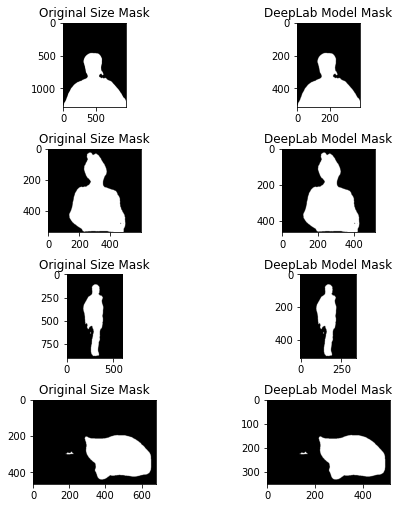

In [108]:
def restoration_img(img_mask, img_orig):
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    return img_mask_up

img_mask_up1 = restoration_img(img_mask1, img_orig1)
img_mask_up2 = restoration_img(img_mask2, img_orig2)
img_mask_up3 = restoration_img(img_mask3, img_orig3)
img_mask_up4 = restoration_img(img_mask4, img_orig4)
img_chromakey_up = restoration_img(img_chromakey, img_orig1) # 크로마키 사진을 1번 이미지와 동일한 사이즈로 변경한다.

plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.5)

ax = plt.subplot(4,2,1)
plt.imshow(img_mask_up1, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(4,2,2)
plt.imshow(img_mask1, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

ax = plt.subplot(4,2,3)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(4,2,4)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

ax = plt.subplot(4,2,5)
plt.imshow(img_mask_up3, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(4,2,6)
plt.imshow(img_mask3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

ax = plt.subplot(4,2,7)
plt.imshow(img_mask_up4, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(4,2,8)
plt.imshow(img_mask4, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

# 배경 흐리게 하기

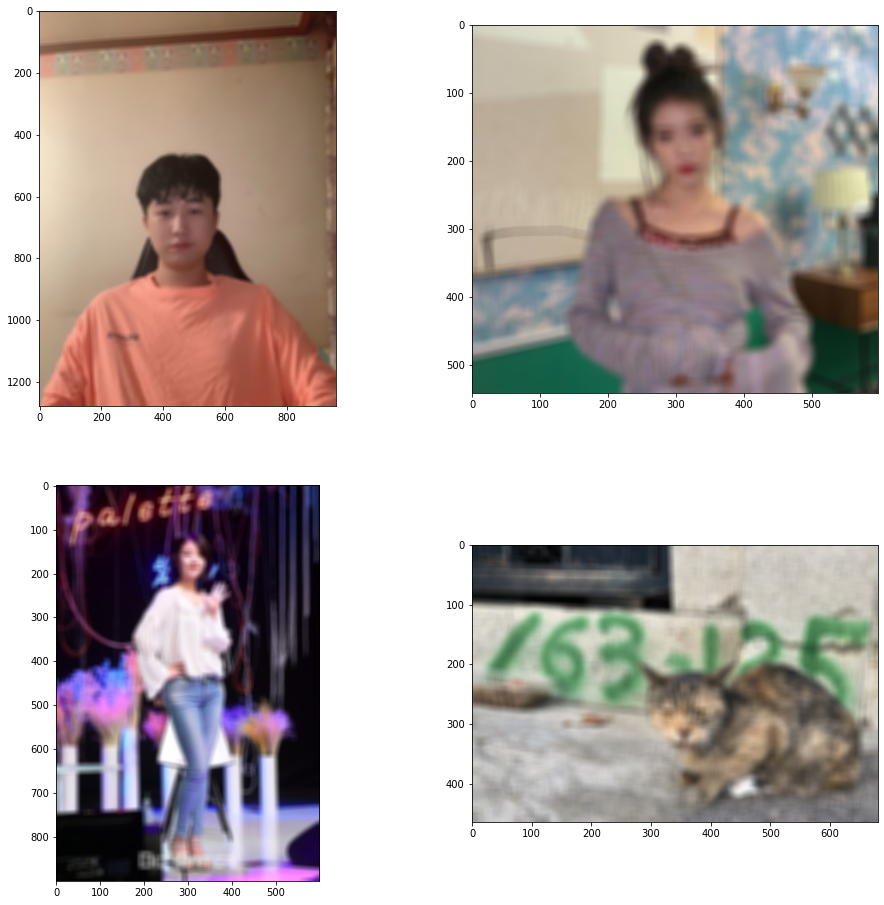

In [113]:
img_orig_blur1 = cv2.blur(img_orig1, (15, 15)) # (13,13)은 blur kernel size를 뜻한다
img_orig_blur2 = cv2.blur(img_orig2, (15, 15)) # (13,13)은 blur kernel size를 뜻한다
img_orig_blur3 = cv2.blur(img_orig3, (15, 15)) # (13,13)은 blur kernel size를 뜻한다
img_orig_blur4 = cv2.blur(img_orig4, (15, 15)) # (13,13)은 blur kernel size를 뜻한다

plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img_orig_blur1, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(img_orig_blur4, cv2.COLOR_BGR2RGB))

plt.show()


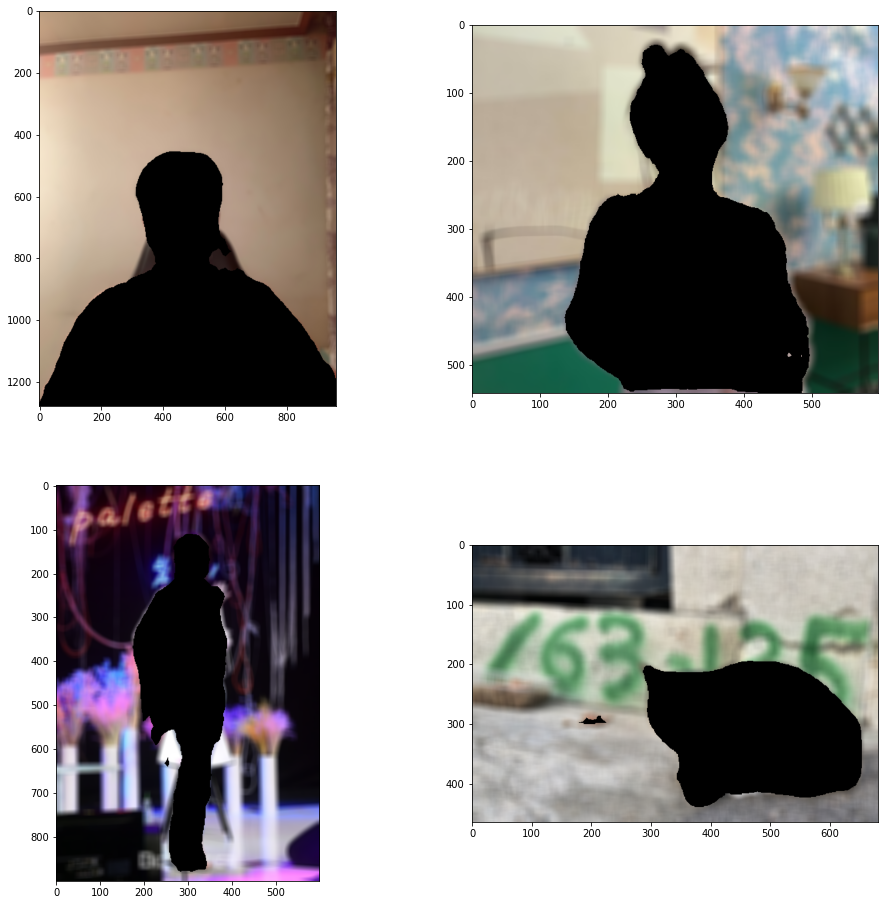

In [114]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
def bg_extract(img_mask_up, img_orig_blur):
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    return img_mask_color, img_bg_blur

img_mask_color1, img_bg_blur1 = bg_extract(img_mask_up1, img_orig_blur1)
img_mask_color2, img_bg_blur2 = bg_extract(img_mask_up2, img_orig_blur2)
img_mask_color3, img_bg_blur3 = bg_extract(img_mask_up3, img_orig_blur3)
img_mask_color4, img_bg_blur4 = bg_extract(img_mask_up4, img_orig_blur4)

plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))

plt.show()

# 흐린 배경과 원본 영상 합성

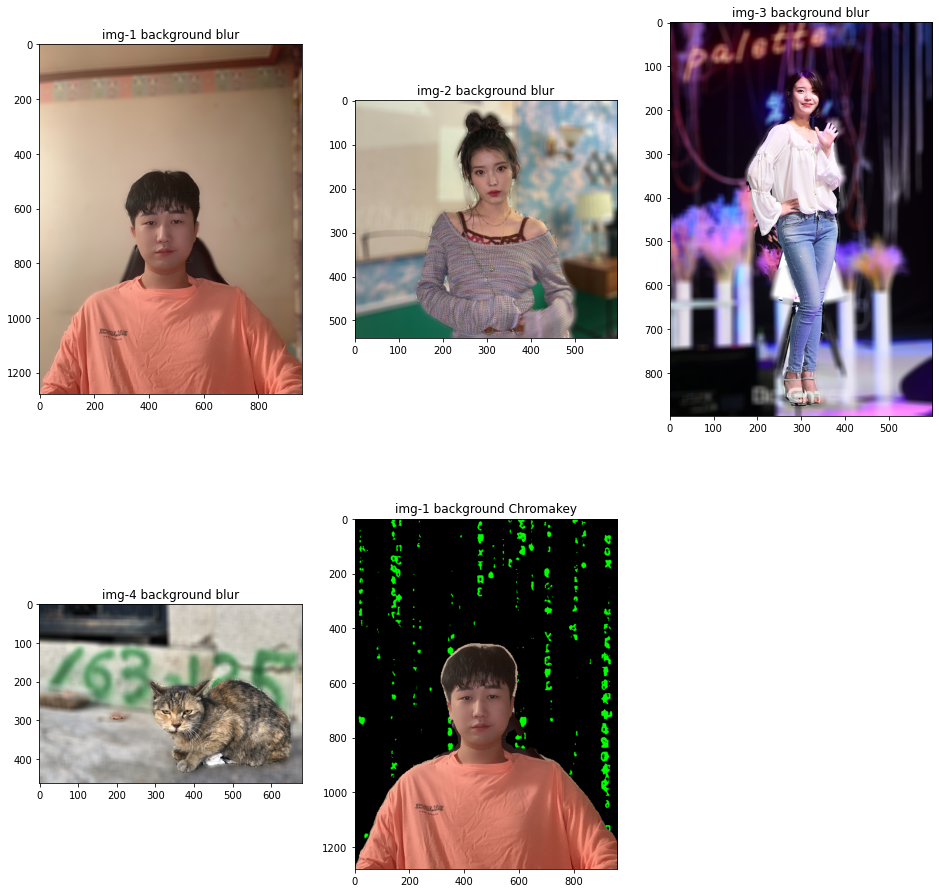

In [117]:
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1) 
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2) 
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3) 
img_concat4 = np.where(img_mask_color4==255, img_orig4, img_bg_blur4) 

img_concat_Chromakey = np.where(img_mask_color1==255, img_orig1, img_chromakey_up) 

plt.figure(figsize=(16,16))

ax = plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
ax.set_title('img-1 background blur')

ax = plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
ax.set_title('img-2 background blur')

ax = plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
ax.set_title('img-3 background blur')

ax = plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
ax.set_title('img-4 background blur')

ax = plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(img_concat_Chromakey, cv2.COLOR_BGR2RGB))
ax.set_title('img-1 background Chromakey')

plt.show()

# 사진에서 문제점 찾기

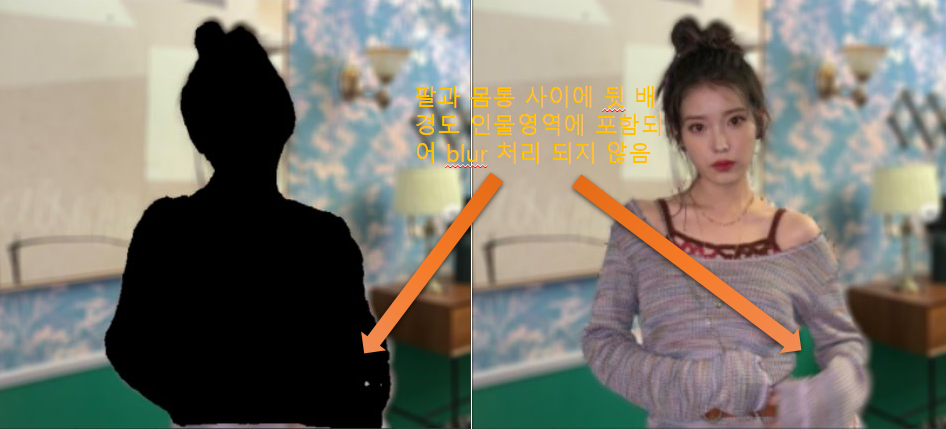

# 해결 방법을 제안해 보자

## 해결안 : Depth Camera 활용

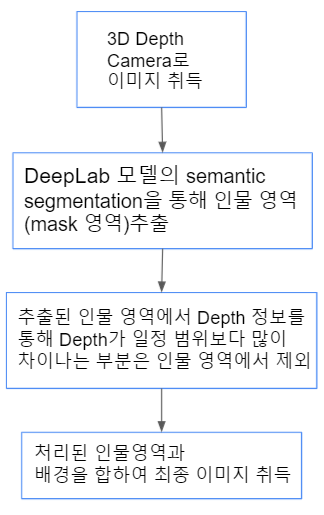
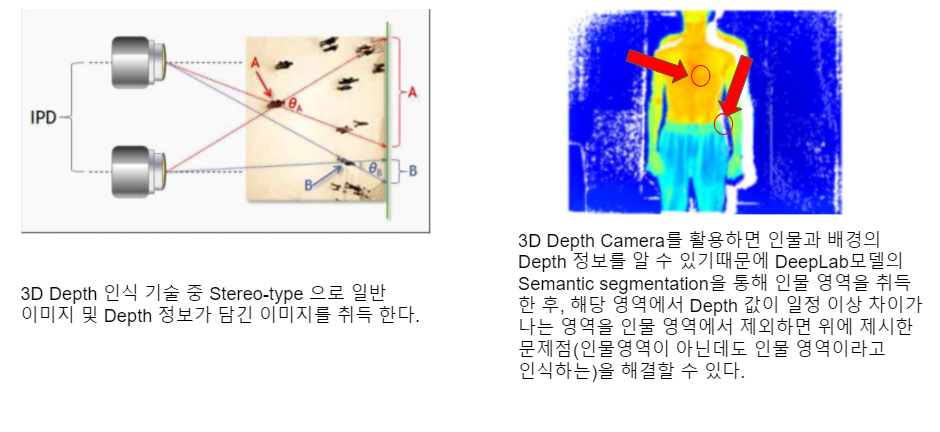

# 회고
> 1. 이번 프로젝트에서 **어려웠던 점,**
>
> 만든 인물 사진에서 문제점의 해결방안을 제시해주는 것이 어려웠다.   
> 노드에서 총 3가지(3D Depth Camera 활용하기, Struct2Depth 라는 기법 활용하기, IR(적외선)을 활용한 사례)를 제시해주었지만
> 3D Depth Camera는 2개 이상의 카메라를 사용하여야 하고, Struct2Depth 라는 기법은 여러장의 이미지를 시간차로 분석하여 활용하는 것이기 때문에   
> 이미 찍어놓은 이미지 1장으로 해당 문제점을 해결하기는 어렵다고 생각한다.


> 2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.   
> 
> Google Meet 에 배경을 다른걸로 바꾸거나 blur 처리하는 기능이 포함되어 있는데 해당 기능을 현재 진행한 노드처럼 하면 되겠구나 라고 생각이 들었다.   
> 또한 Struct2Depth 라는 기법을 보고 매우 흥미롭다고 생각했다.   
> 그래서 노드에서 제시해준 링크로는 이해가 힘들어 해당 기법에 대해 다른 자료를 찾아보려고 했지만 자료가 많지 않아 해당 기법이 정확히 어떤 로직으로   
> 돌아가는지 모호하다.

> 3. 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.   
>
> '문제점의 해결방안' 관련 루브릭 평가 지표를 맞추기 위해 여러 블로그 등의 자료들을 찾아보았다.   

> **자기 다짐**    
> 추후 실력이 된다면 Struct2Depth 기법을 구현해보자.